<h1> Perceptron

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# Caricamento del dataset
data = pd.read_csv('data/training_c.csv')

# Divisione in X (feature) e y (target)
X = data.drop("RiskLevel", axis=1)
y = data['RiskLevel']

# Codifica delle etichette in numeri
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Suddivisione dei dati in training e test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardizzazione delle features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Verifichiamo se il nostro dataset ha un bilanciamento corretto tra le classi.

In [206]:
class_counts = pd.Series(y).value_counts()
class_names = label_encoder.classes_
class_counts.index = class_counts.index.map(lambda x: class_names[x])
print(class_counts)

low risk     404
mid risk     334
high risk    271
Name: count, dtype: int64


In questo caso, la classe 1 è la più rappresentata, seguita dalla classe 2, e infine la classe 0 è quella meno rappresentata. Questo tipo di sbilanciamento può influire negativamente sulle performance del modello, poiché il modello potrebbe essere più propenso a predire la classe più frequente.

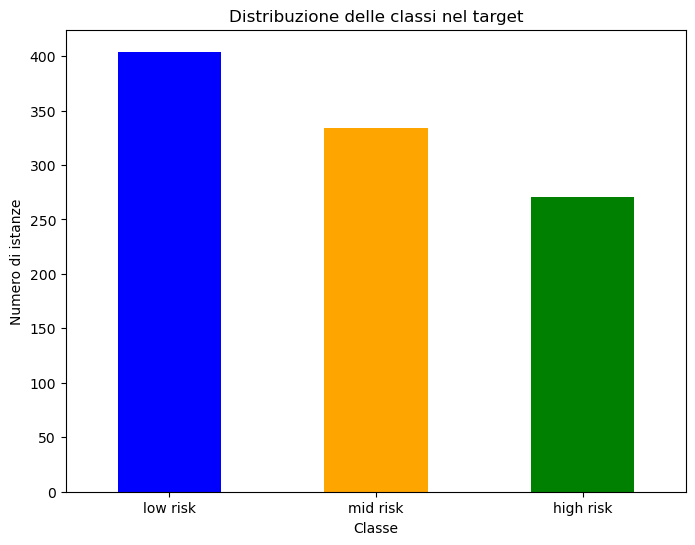

In [207]:
# Visualizzazione della distribuzione delle classi
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green'])  # Aggiungi i colori per differenziare le classi
plt.title("Distribuzione delle classi nel target")
plt.xlabel("Classe")
plt.ylabel("Numero di istanze")
plt.xticks(rotation=0)
plt.show()

Possiamo applicare il bilanciamento dei pesi direttamente nel modello di classificazione impostando il parametro class_weight='balanced'. 

Questo dà un peso maggiore alle classi minoritarie durante l’addestramento.

In [208]:

# Definizione del modello Perceptron
perceptron = Perceptron()

# Parametri da ottimizzare (grid search)
param_grid = {
    'eta0': [0.001, 0.01, 0.1, 1],  # Tasso di apprendimento
    'max_iter': [100, 200, 500, 1000],  # Numero di iterazioni
    'alpha': [0.0001, 0.001, 0.01],  # Regolarizzazione L2
    'class_weight': ['balanced'],  # Bilanciamento delle classi
    'tol': [1e-4, 1e-3, 1e-2]  # Tolleranza per la convergenza
}

# Creazione del GridSearchCV per la ricerca dei migliori parametri
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Allenamento tramite GridSearch
grid_search.fit(X_train, y_train)

# Migliori parametri
print(f"Migliori parametri: {grid_search.best_params_}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Migliori parametri: {'alpha': 0.0001, 'class_weight': 'balanced', 'eta0': 0.1, 'max_iter': 100, 'tol': 0.0001}


In [209]:
# Predizioni sul test set con i migliori parametri
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuratezza: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuratezza: 0.5297
Precision: 0.3550
Recall: 0.5297
F1-score: 0.4243


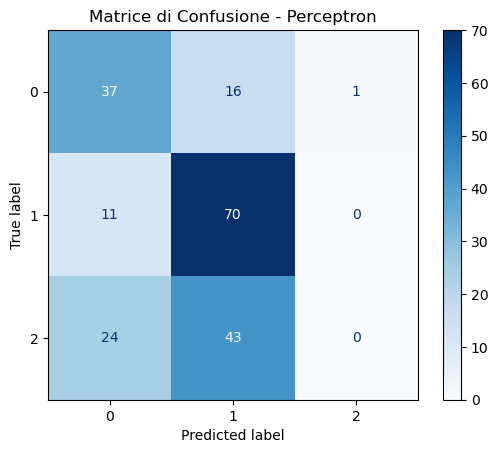

In [210]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Perceptron")
plt.show()

il Percettrone, che rappresenta l’unità fondamentale delle reti neurali è stato utile come punto di partenza, ma le sue limitazioni (linearità) sono evidenti. Nonostante l’uso di tecniche come il bilanciamento delle classi, il modello ha mostrato una performance limitata.

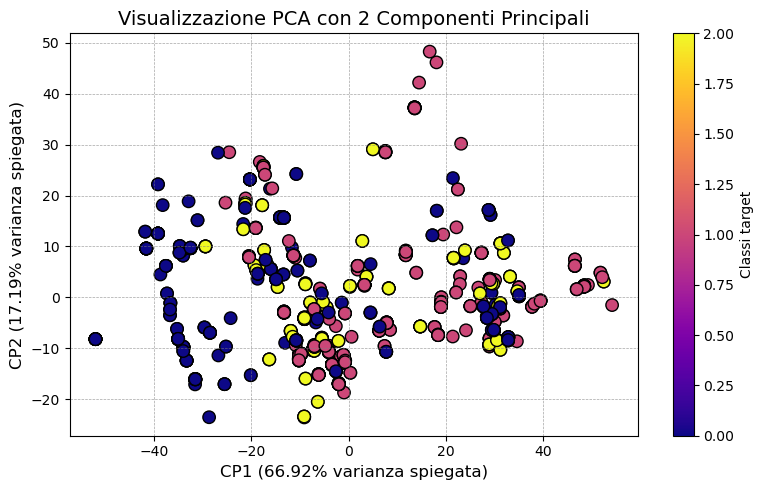

In [211]:
# Riduzione della dimensionalità a 2 componenti principali
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma', edgecolor='k', s=80)
plt.colorbar(scatter, label="Classi target")
plt.title('Visualizzazione PCA con 2 Componenti Principali', fontsize=14)
plt.xlabel(f'CP1 ({explained_var[0]*100:.2f}% varianza spiegata)', fontsize=12)
plt.ylabel(f'CP2 ({explained_var[1]*100:.2f}% varianza spiegata)', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

La distribuzione dei dati lungo le due componenti principali non appare perfettamente separata in modo lineare. 

Sebbene ci siano delle aree in cui i punti di una classe sono concentrati, alcune aree mostrano sovrapposizioni tra classi diverse. 
Questo indica che, anche dopo la riduzione dimensionale tramite PCA, ci sono potenziali relazioni non lineari tra le classi.

Il passaggio dal percettrone al MLP rappresenta un’evoluzione naturale per affrontare un problema di classificazione più complesso. 

L’MLP sfrutta pienamente le relazioni non lineari presenti nei dati, migliorando le prestazioni e portando a un modello più robusto e generalizzabile.

<h1>MLP

La scelta di passare al MLP è stata naturale per affrontare problemi non lineari. L’architettura a strati del MLP permette di modellare relazioni complesse tra le feature. Abbiamo ottenuto un notevole miglioramento delle performance grazie all’aggiunta di più livelli nascosti e all’ottimizzazione dei parametri.

Proviamo, come prima cosa, ad allenare un MLP default(iperparametri default di SciKitLearn):

In [263]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Creazione del modello MLP con parametri di default
mlp_default = MLPClassifier(random_state=42, max_iter=5000)  # Solo random_state per riproducibilità

# Allenamento del modello sul dataset bilanciato
mlp_default.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = mlp_default.predict(X_test)

# Valutazione del modello
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calcolo dell'accuratezza con k-fold cross-validation (k=5)
accuracies = cross_val_score(mlp_default, X_train, y_train, cv=5, scoring='accuracy')

# Media e deviazione standard delle accuratezze
print(f"Accuratezza media con Cross-Validation: {accuracies.mean():.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        54
           1       0.70      0.79      0.74        81
           2       0.69      0.54      0.61        67

    accuracy                           0.72       202
   macro avg       0.73      0.73      0.72       202
weighted avg       0.72      0.72      0.72       202

Accuratezza media con Cross-Validation: 0.7187


Il modello risulta avere prestazioni scarse, con precisione (0.69) e recall (0.54), sulla classe 2.

Con la distribuzione delle classi, abbiamo visto che le classi meno rappresentate del dataset sono la 1(midRisk) e la 2(lowRisk)

Il modello non “vede abbastanza dati” per imparare adeguatamente le caratteristiche di queste classi.

Questo si riflette in un F1-score più basso per queste classi, specialmente per la classe 2.

La soluzione più semplice e diretta è sfruttare tecniche di bilanciamento in scikit-learn. 

Queste ribilanciano il peso di ogni classe in base alla sua frequenza nel dataset, penalizzando gli errori sulle classi minoritarie più di quelli sulla classe maggioritaria.

In [265]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
# Modello MLP con SMOTE'
# SMOTE (Synthetic Minority Over-sampling Technique): è una tecnica di oversampling che crea campioni sintetici per le classi minoritarie in un dataset sbilanciato. 
# Viene utilizzata per risolvere il problema di class imbalance (disequilibrio tra le classi).
# Bilanciamento delle classi con SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_bal, y_bal = smote.fit_resample(X_train, y_train)

mlp = MLPClassifier(random_state=42 ,max_iter=5000)
mlp.fit(X_bal, y_bal)
y_pred = mlp.predict(X_test)
# Calcolo dell'accuratezza con k-fold cross-validation (k=5)
accuracies = cross_val_score(mlp_default, X_train, y_train, cv=5, scoring='accuracy')
# Media e deviazione standard delle accuratezze
print(f"Accuratezza media con Cross-Validation: {accuracies.mean():.4f}")
print(classification_report(y_test, y_pred))

Accuratezza media con Cross-Validation: 0.7187
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        54
           1       0.73      0.85      0.78        81
           2       0.81      0.63      0.71        67

    accuracy                           0.78       202
   macro avg       0.79      0.78      0.78       202
weighted avg       0.78      0.78      0.77       202



In [266]:

from sklearn.model_selection import GridSearchCV


# Definizione della griglia per la ricerca dei parametri ottimali tramite GridSerachCV

param_grid = {
    'hidden_layer_sizes': [(100,),(50,50), (100, 50)],# Combinazioni di neuroni negli strati nascosti
    'activation': ['relu', 'tanh'],# Funzioni di attivazione comuni
    'alpha': [0.001, 0.01],# Regularization strength (penalizzazione della complessità)
    'learning_rate_init': [0.001, 0.01]# Velocità di apprendimento iniziale
}

# GridSearchCV per trovare i parametri migliori
grid_search = GridSearchCV(estimator=mlp, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='f1_weighted', 
                           n_jobs=-1, 
                           verbose=2,
                           return_train_score=True)


grid_search.fit(X_bal, y_bal)  # Allenamento sul dataset bilanciato

#Migliori parametri trovati
print(f"Migliori parametri: {grid_search.best_params_}")



Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001; total time=   1.4s
[CV] END activation=relu, alpha=0.001, hidden_l

In [267]:
#Miglior modello allenato
best_mlp = grid_search.best_estimator_

# Predizioni sul test set
y_pred = best_mlp.predict(X_test)

# Calcolo delle metriche di valutazione
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza: {accuracy:.4f}")

# Stampa del classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuratezza: 0.8218
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        54
           1       0.80      0.86      0.83        81
           2       0.80      0.76      0.78        67

    accuracy                           0.82       202
   macro avg       0.83      0.82      0.82       202
weighted avg       0.82      0.82      0.82       202



Proviamo a modificare la soglia di decisione per la classe 2.

Abbassare la soglia per la classe 2 è una strategia mirata a migliorare il recall per quella classe, ed è utile quando si vuole ridurre il numero di falsi negativi

In [268]:
# Predizioni delle probabilità
probas = best_mlp.predict_proba(X_test)

# Inizializza un array per le predizioni finali
y_pred_custom = np.zeros_like(y_test)

# Applica la soglia personalizzata per la classe 2
for i in range(len(probas)):
    if probas[i, 2] > 0.3:  # Cambia soglia per la classe 2
        y_pred_custom[i] = 2
    else:
        # Predici la classe con probabilità massima tra 0 e 1
        y_pred_custom[i] = np.argmax(probas[i, :2])

# Calcola le metriche
accuracy_custom = accuracy_score(y_test, y_pred_custom)
print(f"Accuratezza (con soglia personalizzata): {accuracy_custom:.4f}")

print("Classification Report (con soglia personalizzata):")
print(classification_report(y_test, y_pred_custom))

Accuratezza (con soglia personalizzata): 0.8564
Classification Report (con soglia personalizzata):
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        54
           1       0.88      0.85      0.87        81
           2       0.81      0.88      0.84        67

    accuracy                           0.86       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.86      0.86      0.86       202



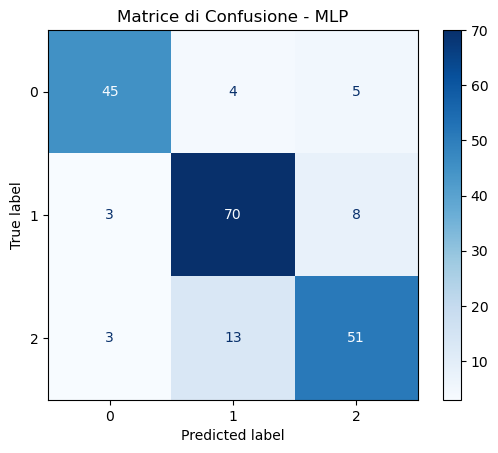

In [269]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - MLP")
plt.show()

Validation Curve

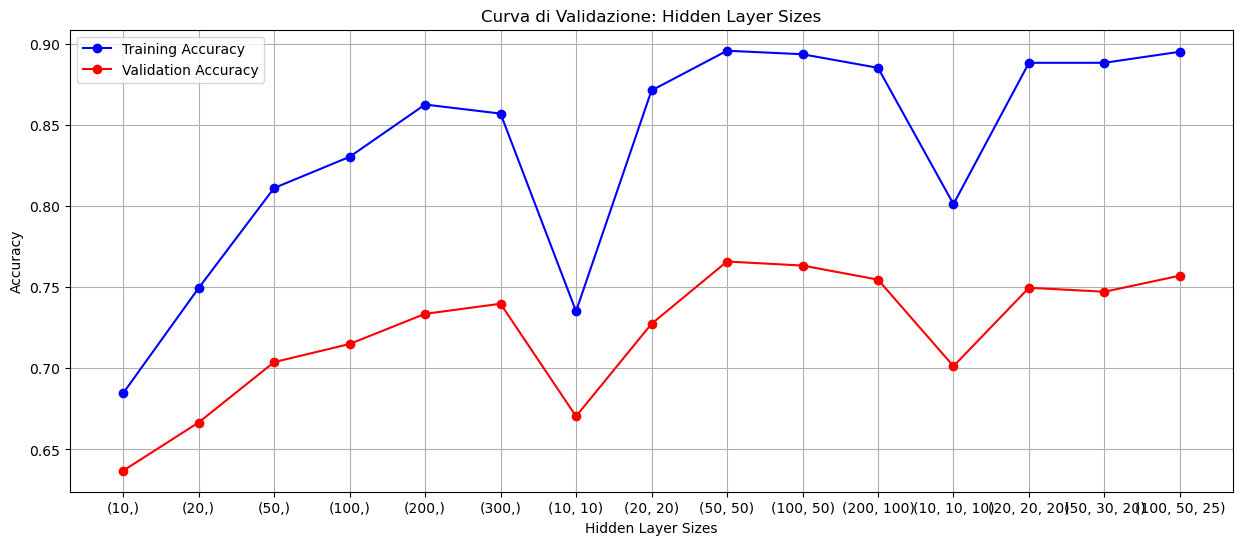

In [270]:

# Parametri per la curva di validazione
param_name = 'hidden_layer_sizes'
param_range = param_range = [
    (10,), (20,), (50,), (100,), (200,), (300,),      # Strati singoli
    (10, 10), (20, 20), (50, 50), (100, 50), (200, 100),  # Due strati
    (10, 10, 10), (20, 20, 20), (50, 30, 20), (100, 50, 25)  # Tre strati
]  # Valori da testare

# Calcolo della curva di validazione
train_scores, val_scores = validation_curve(
    best_mlp, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1
)

# Calcolo delle medie
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot della curva di validazione
plt.figure(figsize=(15, 6))
plt.plot([str(p) for p in param_range], train_mean, label='Training Accuracy', color='blue', marker='o')
plt.plot([str(p) for p in param_range], val_mean, label='Validation Accuracy', color='red', marker='o')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Curva di Validazione: Hidden Layer Sizes')
plt.legend()
plt.grid()
plt.show()

Modelli troppo complessi (es. (200, 100)): elevata training accuracy ma bassa validation accuracy → overfitting.

Modelli troppo semplici (es. (10,), (20,)): sia training che validation accuracy sono basse → underfitting.

Valori intermedi come (50, 50),(50,100) offrono un buon bilanciamento tra accuratezza e complessità.

Learning curve

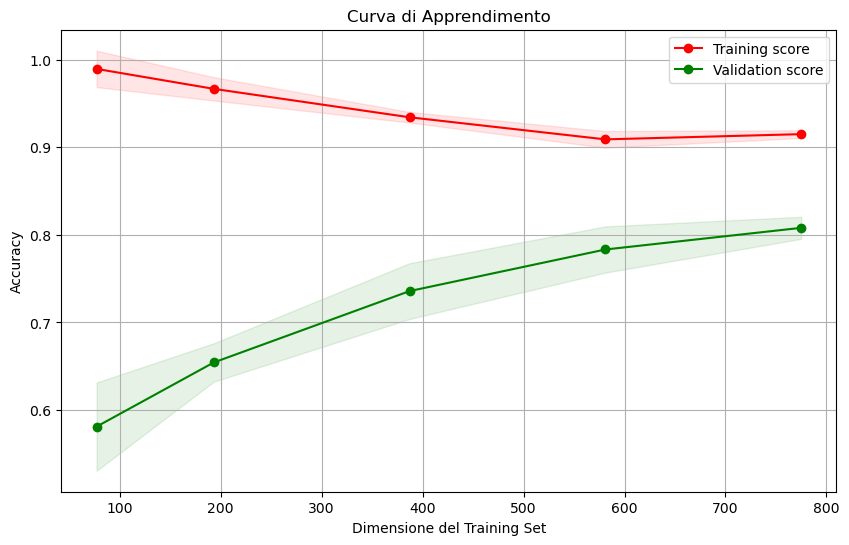

In [271]:
# Curva di apprendimento
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, X_bal, y_bal, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=[0.1, 0.25, 0.5, 0.75, 1.0]
)

# Calcolo delle medie e deviazioni standard
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Dimensione del Training Set")
plt.ylabel("Accuracy")
plt.title("Curva di Apprendimento")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Loss curve

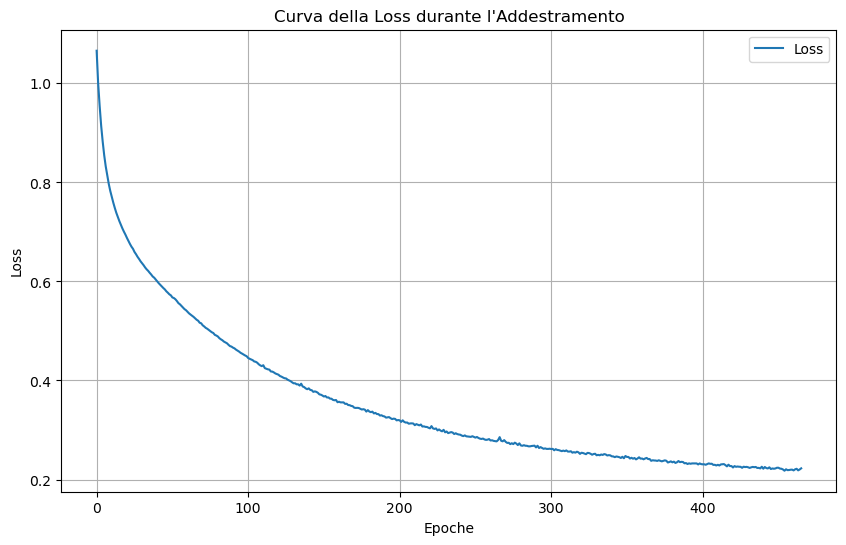

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_, label='Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Curva della Loss durante l\'Addestramento')
plt.legend()
plt.grid()
plt.show()